In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [14]:

import iface

def load_base_matrix():  
    with open('riga49.csv', 'r') as file:
        return iface.read_matrix(file)
    # return np.genfromtxt('riga49.csv', delimiter=',')
    
    
def generate_matrix(q):
    t = load_base_matrix()
    return np.block([[t] * q] * q)

In [17]:
q = 2**5
A = generate_matrix(q)
B = A
AxB = A@B
T = load_base_matrix()

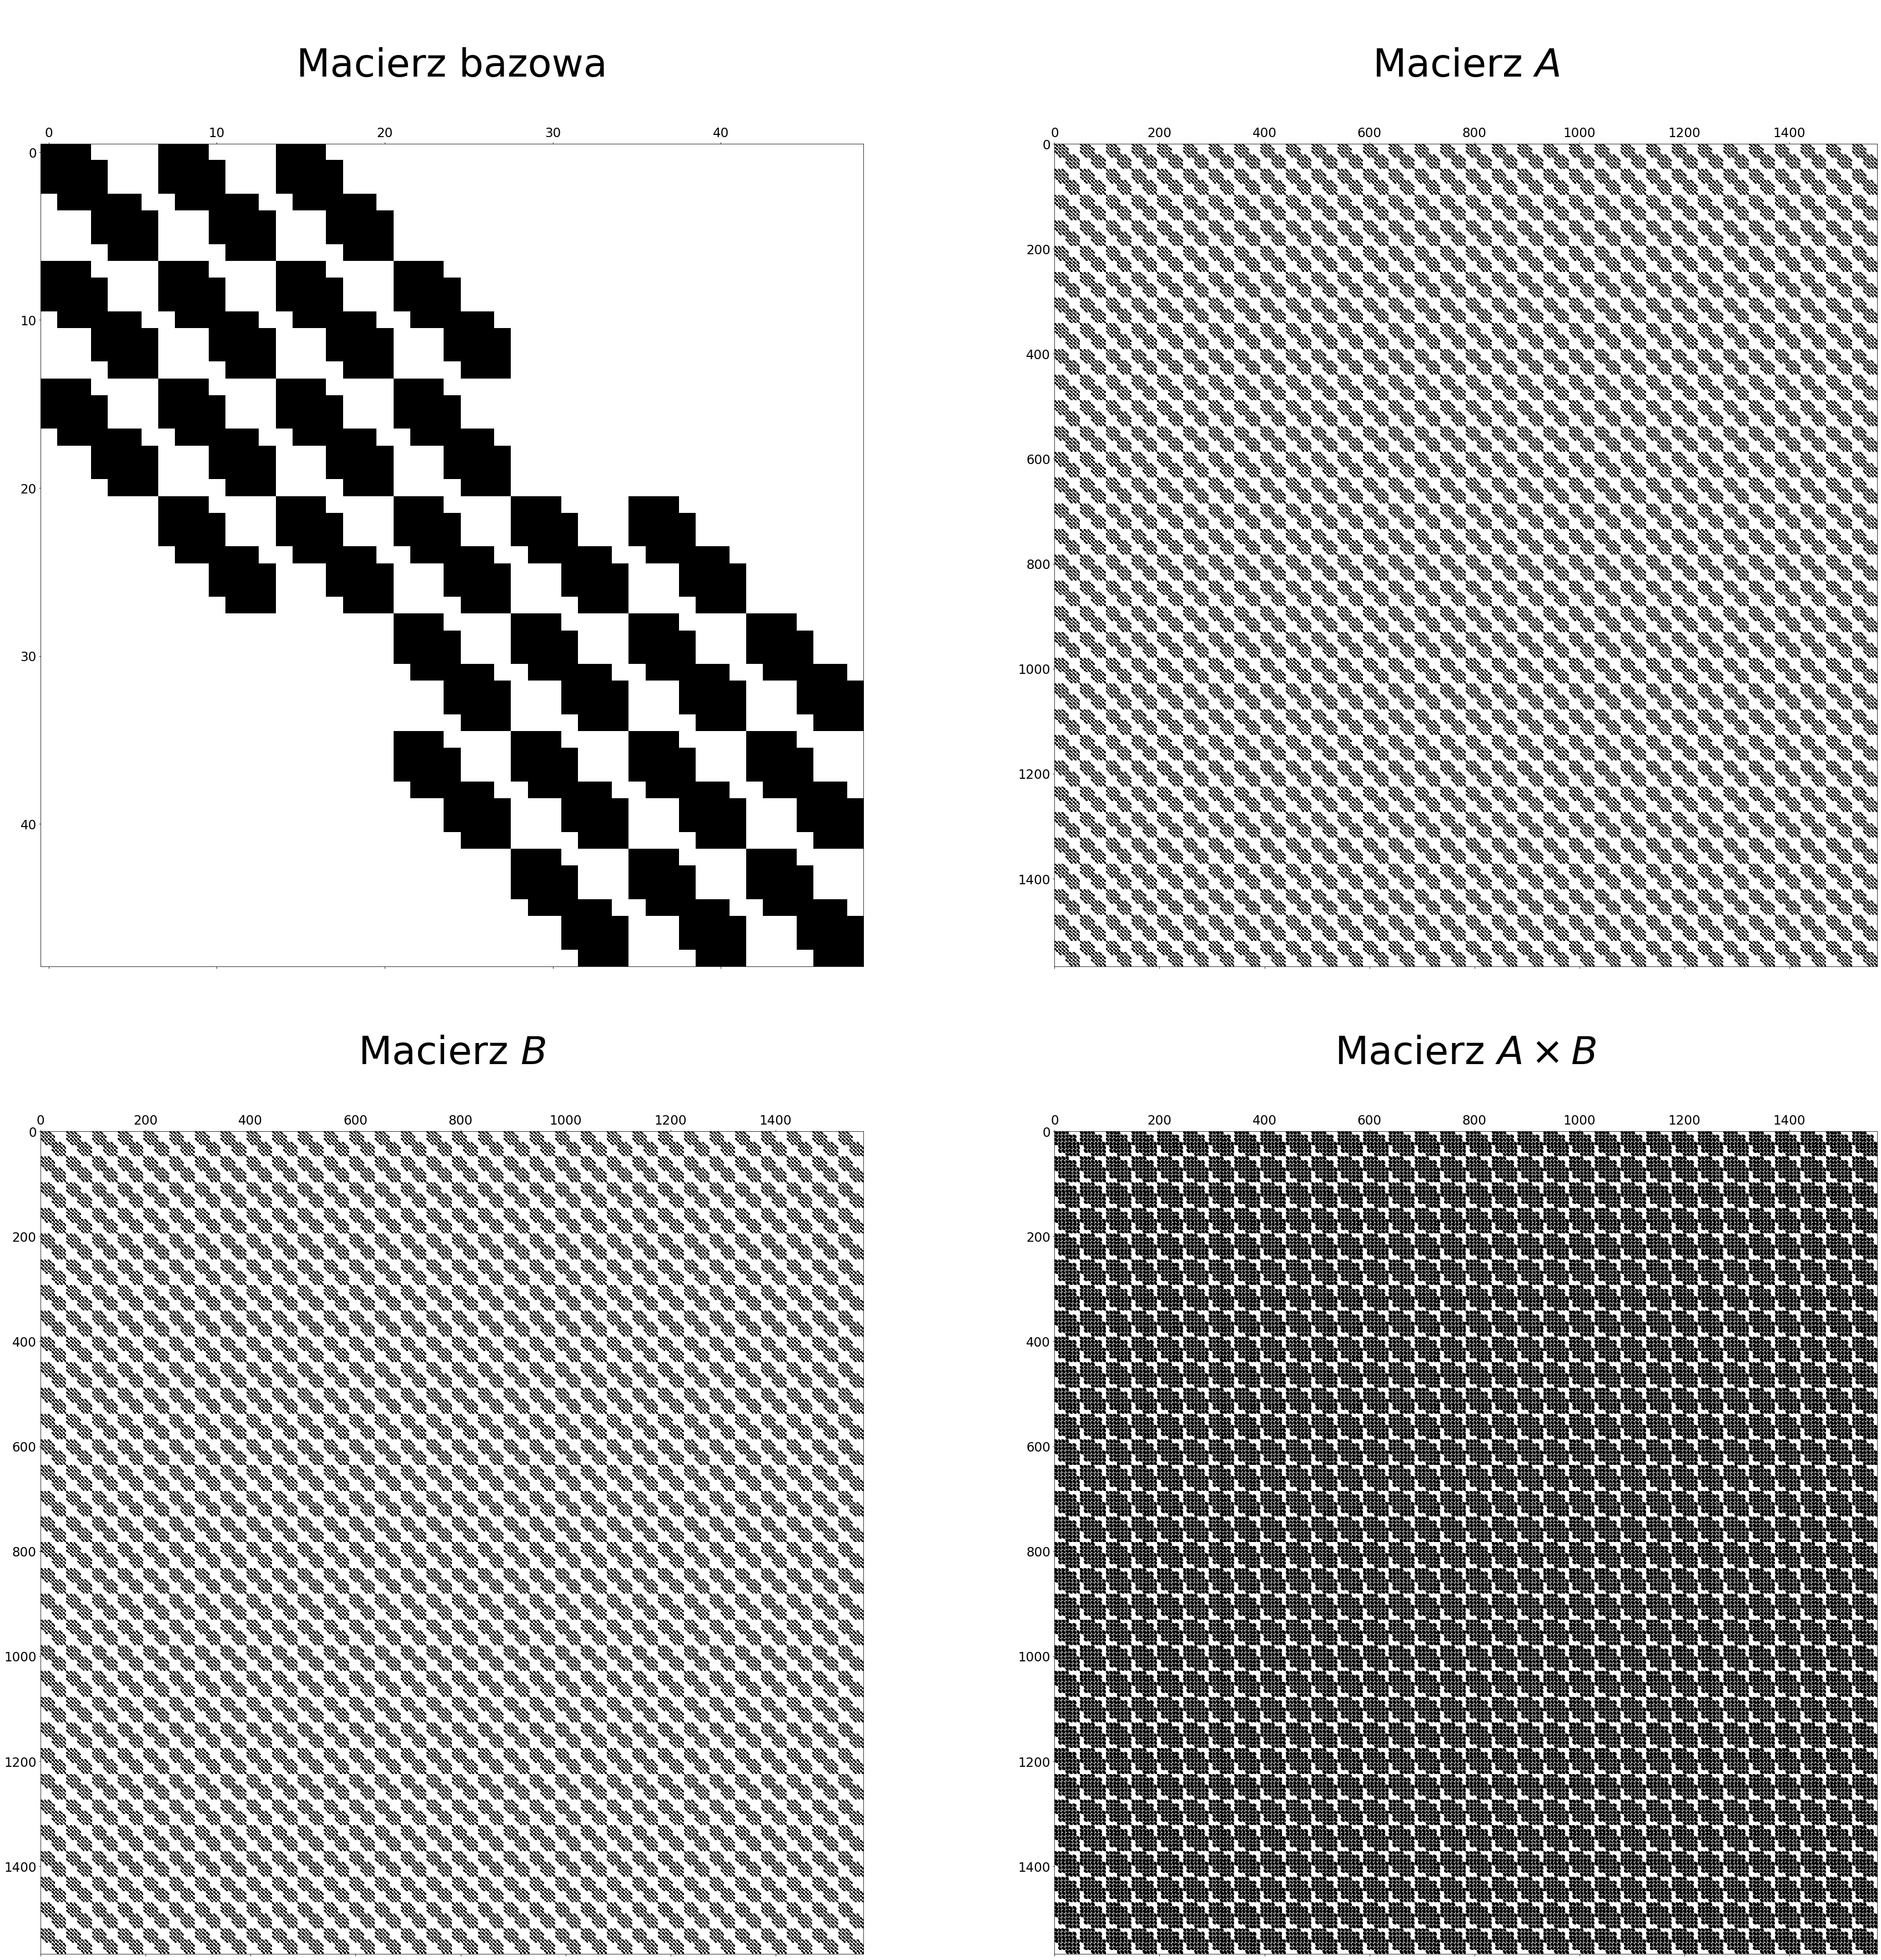

In [22]:
fig, axs = plt.subplots(2, 2, figsize = (60, 60))
axs = axs.flatten()

matrices = [T, A, B, AxB]
titles = ['Macierz bazowa', 'Macierz $A$', 'Macierz $B$', 'Macierz $A \\times B$']


for ax, matrix, title in zip(axs, matrices, titles):
    ax.spy(matrix)
    ax.set_title(f'\n{title}\n', fontsize=70)
    ax.tick_params(axis='both', labelsize=23)
    
plt.show()

In [24]:
from iface import calc

representations = [
    'dense',
    'coord'
] 

def measure_time(A, B, representations=representations, tries=1):
    res_df = []
    for representation in representations:
        sum_time_prep = 0
        sum_time_calc = 0
        for _ in range(tries):
            time_prep, time_calc, _ = calc(A, B, representation)
            sum_time_prep += time_prep
            sum_time_calc = time_calc
        avg_time_prep = sum_time_prep / tries
        avg_time_calc = sum_time_calc / tries
        res_df.append([representation, avg_time_prep, avg_time_calc])
        print(f'{representation}: preparation - {avg_time_prep:.2f}s, calculation - {avg_time_calc: .2f}s')
    res = pd.DataFrame(res_df, columns=('representation', 'avg_time_prep', 'avg_time_calc'))
    res['avg_time_whole'] = res['avg_time_prep'] + res['avg_time_calc'] 
    return res

In [25]:
res_df = measure_time(A, B, tries=1)
res_df.rename(columns={'representation': 'Representation', 'avg_time_prep': 'Average preparation time [s]', 'avg_time_calc': 'Average calculation time [s]', 'avg_time_whole': 'Average time [s]'})

FileNotFoundError: [WinError 2] The system cannot find the file specified